## Convolutional Neural Network 활용
-----
- CNN을 구성하는 주요 연산을 이해하고, 신경망을 설계한다.
- AlexNet을 사용하여 이미지를 학습하고 10개의 카테고리를 갖는 이미지를 분류하는 이미지 분류기를 생성한다. (데이터셋: [CIFAR](https://pytorch.org/vision/0.9/datasets.html#cifar))
- 이미지 증강을 수행하여 모델의 성능을 높이는 방법을 이해한다.
- Confusion Matrix를 생성하여 분류 정확도를 확인한다.
- **reference**
    - https://tutorials.pytorch.kr/beginner/basics/buildmodel_tutorial.html
    - https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html
    - https://medium.com/@djin31/how-to-plot-wholesome-confusion-matrix-40134fd402a8

# 1번
- 필요한 모듈을 모두 이곳에 나열하세요
- 2점

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 2번
- CIFAR 데이터(train, test)를 불러오세요
- 2점

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:02<00:00, 72500406.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 3번
- 불러온 이미지의 증강을 합니다.
- RandomCrop, RandomHorizontalFlip, Normalize
- Compose 함수를 이용합니다.
- train에는 RandomCrop(28, padding=4), RandomHorizontalFlip, Normalize를 적용한다.
- test에는 Normalize를 적용한다.
- 2점

In [4]:
trainset.transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [5]:
testset.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 4번
- Device 설정은 GPU로 합니다
- 2점

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# 5번
- train, test의 shape를 확인합니다.
- 2점

In [7]:
print("Trainset shape:", trainset.data.shape)
print("Testset shape:", testset.data.shape)

Trainset shape: (50000, 32, 32, 3)
Testset shape: (10000, 32, 32, 3)


# 6번
- train, test DataLoader를 만듭니다.
- 배치사이즈: 128
- 2점

In [8]:
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


# 7번
- train, test의 첫번째 인덱스 데이터를 이미지로 확인합니다.
- 2점

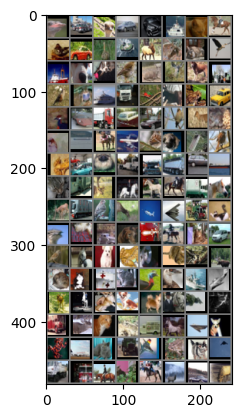

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# 8번
- 아래 코드를 실행해서 labels_map 객체를 딕셔너리로 생성합니다.
- 2점

In [10]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

# 9번
- 5행 5열로 train 데이터를 이미지로 출력합니다.
- labels_map를 이용하여 이미지의 label도 함께 출력합니다.
- 2점

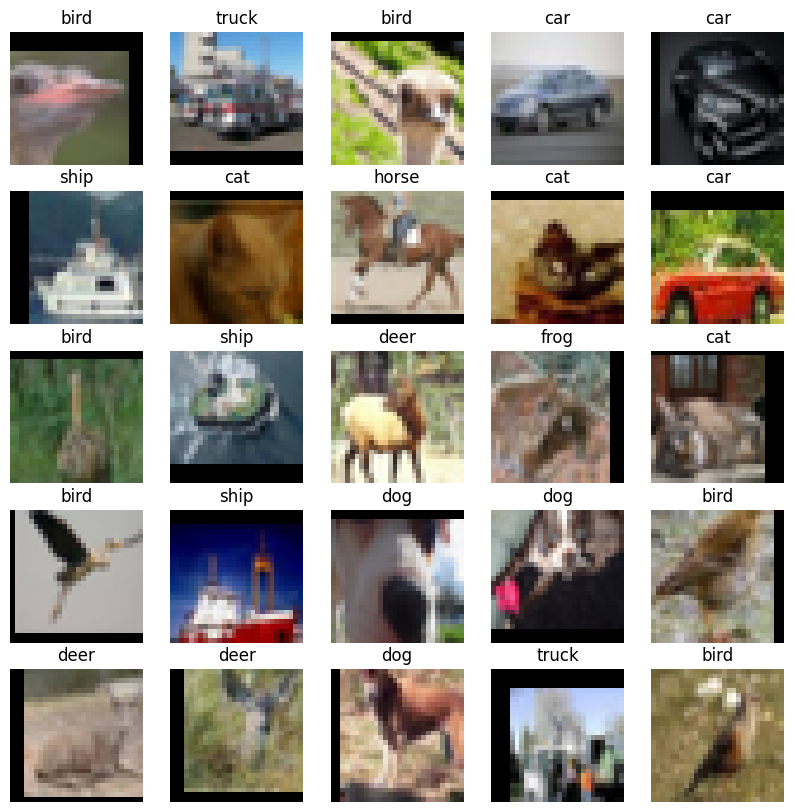

In [11]:
def imshow_labels(images, labels):
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(np.transpose(images[i * 5 + j] / 2 + 0.5, (1, 2, 0)))
            axs[i, j].set_title(labels_map[labels[i * 5 + j].item()])
            axs[i, j].axis('off')
    plt.show()

imshow_labels(images, labels)

# 10번
- AlexNet(https://en.wikipedia.org/wiki/File:Comparison_image_neural_networks.svg)
- 위 모델을 참조하여 class를 만듭니다.
- 2점

In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




# 11번
- 인공신경망 객체를 GPU에 저장합니다.
- 3점

In [13]:
net = AlexNet().to(device)

# 12번
- Loss 함수를 정의합니다.
- 학습률을 0.001로 설정합니다.
- 옵티마이저는 Adam을 사용합니다.
- 3점

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


# 13번
- 학습 함수를 train_loop로 작성합니다.
- 매개변수(데이터로더, 모델, loss 함수, 옵티마이저)
- 데이터로더의 인덱스가 배치사이즈마다 loss를 출력합니다.
- 3점

In [23]:
def train_loop(trainloader, model, criterion, optimizer):
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Batch {i}, Loss: {loss.item()}")

# 14번
- 테스트 함수를 test_loop로 작성합니다.
- 매개변수(데이터로더, 모델, loss 함수)
- 데이터로더의 크기만큼 반복하며 loss를 출력하고 전체 accuracy와 평균 loss를 구합니다.
- 3점

In [24]:
def test_loop(testloader, model, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(testloader)
    accuracy = correct / total
    print(f"Test Loss: {average_loss:.3f}, Accuracy: {accuracy:.3%}")

# 15번
- 100번의 epochs를 돌며 학습을 반복합니다.
- 3점

In [25]:
for epoch in range(100):
    train_loop(trainloader, net, criterion, optimizer)


RuntimeError: Given input size: (192x2x2). Calculated output size: (192x0x0). Output size is too small

# 16번
- 사이킷런의 confusion_matrix를 활용해 학습된 결과에 대해 분석합니다.
- 분석한 결과를 간단히 서술합니다.
- 3점

# 17번
- 학습된 파라미터를 저장합니다.
- 파일명은 model_weights.pth로 합니다.
- 3점

# 18번
- 새로운 인공신경망을 GPU에 만들고 위 학습된 파일(model_weights.pth)을 불러옵니다.
- 3점

# 19번
- 위 모델에 test 데이터로더를 입력하고 결과를 확인합니다.
- 3점

# 20번
- 5행 5열로 test 데이터를 이미지로 출력합니다.
- 학습된 모델이 분류기가 잘 작동하는지 label과 예측된 결과를 동시에 출력합니다.
- 3점